```{index} disjunctive programming
```
```{index} boolean variables
```
```{index} single: Pyomo; boolean 
```

# Extra material: Strip packing

*Strip packing* (SP) refers to the problem of packing rectangles onto a 2-dimensional strip of fixed width. 

Many variants of this problem have been studied, the most basic is the pack a set of rectangles onto the shortest possible strip without rotation. Other variants allow rotation of the rectangles, require a packing that allows cutting the rectangles out of the strip with edge-to-edge cuts (guillotine packing), extends the strip to three dimensions, or extends the packing to non-rectangular shapes.

The extensive study of strip packing problems is motivated by their many industrial applications including

* placement of macro cells in semiconductor layouts,
* wood and textile cutting operations,
* laying out workstations in manufacturing facilities,
* allocating communications bandwidth between two endpoints,
* planning and scheduling $CO_2$ utilization for enhanced oil recovery,
* scheduling allocations of a common resource.

Finding optimal solutions to strip packing problems is combinatorially difficult. Strip packing belongs to a class of problems called "NP-hard" for which known solution algorithms require effort that grows exponentially with problem size. For that reason much research on strip packing has been directed towards practical heuristic algorithms for finding good, though not optimal, for industrial applications.

In this notebook, we illustrate Pyomo models to find optimal solutions to smaller but economically relevant problems. We use the problem of packing boxes onto the shortest possible shelf of fixed depth.

## Preamble: Install Pyomo and a solver

The following cell sets and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and the HiGHS solver, while, if run elsewhere, it assumes Pyomo and HiGHS have been previously installed. It then sets to use HiGHS as solver via the appsi module and a test is performed to verify that it is available. The solver interface is stored in a global object `SOLVER` for later use.

In [1]:
import sys
 
if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null
 
solver = 'appsi_highs'

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)
 
assert SOLVER.available(), f"Solver {solver} is not available."

## Problem Statment

Assume you are given a collection of $N$ boxes, whose dimensions are $(w_i, d_i)$ for $i=0, \ldots, N-1$. These boxes are to placed on shelf of depth $D$. The boxes can be rotated, if needed, to fit on the shelf. How wide of a shelf is needed?

We will start by creating a function to generate a table of $N$ boxes. For concreteness, we assume the dimensions are in millimeters.

In [2]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pyomo.environ as pyo
import pyomo.gdp as gdp


def generate_boxes(N, max_width=200, max_depth=200):
    rng = random.Random(2023)
    boxes = pd.DataFrame()
    boxes["w"] = [rng.randint(int(0.2 * max_width), max_width) for i in range(N)]
    boxes["d"] = [rng.randint(int(0.2 * max_depth), max_depth) for i in range(N)]
    return boxes


# set the number N of boxes and generate their dimensions at random
N = 8
boxes = generate_boxes(N)
display(boxes)

# set shelf width as a multiple of the deepest box
D = 2 * boxes["d"].max()
print("Shelf Depth = ", D)

,w,d
0,138,71
1,154,117
2,139,176
3,121,175
4,196,117
5,186,85
6,126,99
7,65,85


Shelf Depth =  352


## A lower and upper bounds on shelf width

A lower bound on the shelf width can be obtained by dividing the total area required to place all boxes on the shelf by the shelf depth. The area of box $i$ is $w_i d_i$, therefore the lower bound is given by

$$W_{lb} = \frac{1}{D}\sum_{i=0}^{N-1} w_i d_i.$$

An upper bound on the shelf width $W_{ub}$ can be obtained aligning the boxes along the front of the shelf without rotation. To set the stage for later calculations, the position of box $i$ on the shelf is defined by the coordinates $(x_{i,1}, y_{i,1})$ and $(x_{i,2}, y_{i,2})$, corresponding to the lower left corner and the upper right corner, respectively. 

The two set of coordinates of box $i$ are linked to the width $w_i$ and depth $d_i$ by the following equations:

$$
\begin{align*}
x_{i,2} & = x_{i,1} + w_i \\
y_{i,2} & = y_{i,1} + d_i
\end{align*}
$$

An additional binary variable $r_i$ designates whether the rectangle has been rotated, with $r_i=0$ denoting no rotation and $r_i=1$ denoting a 90 degree rotation (all other rotations yield one of these two configurations). 

The following cell create and display a data frame showing the bounding boxes and performs calculations to obtain the trivial box arrangement, as well as the lower and upper bounds.

,w,d,x1,x2,y1,y2,r
0,138,71,0,138,0,71,0
1,154,117,138,292,0,117,0
2,139,176,292,431,0,176,0
3,121,175,431,552,0,175,0
4,196,117,552,748,0,117,0
5,186,85,748,934,0,85,0
6,126,99,934,1060,0,99,0
7,65,85,1060,1125,0,85,0


Lower bound on shelf width = 370
Upper bound on shelf width = 1125


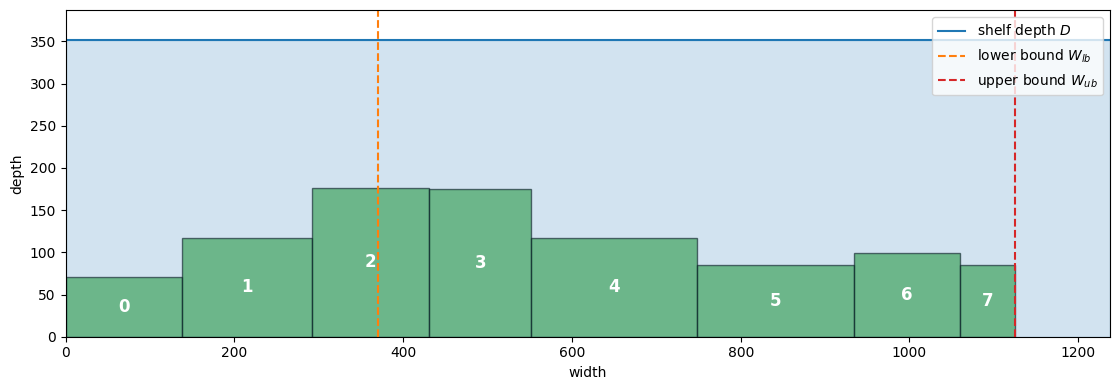

In [3]:
def pack_boxes_V0(boxes):
    soln = boxes.copy()
    soln["x1"] = soln["w"].cumsum() - soln["w"]
    soln["x2"] = soln["w"].cumsum()
    soln["y1"] = 0
    soln["y2"] = soln["d"]
    soln["r"] = 0

    return soln


def show_boxes(soln, D, W_ub=None):
    tab20 = plt.get_cmap("tab20", 20)
    colors = [tab20(i) for i in [0, 2, 4, 6, 8]]

    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    for i, x, y, w, h, r in zip(
        soln.index, soln["x1"], soln["y1"], soln["w"], soln["d"], soln["r"]
    ):
        c = "g"
        if r:
            h, w = w, h
            c = "r"
        ax.add_patch(
            Rectangle((x, y), w, h, edgecolor="k", facecolor=colors[2], alpha=0.6)
        )
        xc = x + w / 2
        yc = y + h / 2
        ax.annotate(
            i, (xc, yc), color="w", weight="bold", fontsize=12, ha="center", va="center"
        )

    W_lb = (soln["w"] * soln["d"]).sum() / D
    W = soln["x2"].max()

    print(f"Lower bound on shelf width = {W_lb:.0f}")
    if W_ub is None:
        print(f"Upper bound on shelf width = {W:.0f}")
    else:
        print(f"Upper bound on shelf width = {W_ub:.0f}")
        print(f"Optimal shelf width = {W:.0f}")

    ax.set_xlim(0, 1.1 * soln["w"].sum())
    ax.set_ylim(0, D * 1.1)
    ax.axhline(D, label="shelf depth $D$", color=colors[0], lw=1.5)
    ax.axvline(W_lb, label="lower bound $W_{lb}$", color=colors[1], lw=1.5, ls="--")
    if W_ub is None:
        ax.axvline(W, label="upper bound $W_{ub}$", color=colors[3], lw=1.5, ls="--")
    else:
        ax.axvline(
            W_ub + 2, label="upper bound $W_{ub}$", color=colors[3], lw=1.5, ls="--"
        )
        ax.axvline(W, label="optimal solution $W$", color=colors[4], lw=1.5, ls="-")
    ax.fill_between([0, ax.get_xlim()[1]], [D, D], color=colors[0], alpha=0.2)
    ax.set_xlabel("width")
    ax.set_ylabel("depth")
    ax.set_aspect("equal")
    ax.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


soln = pack_boxes_V0(boxes)
display(soln)
show_boxes(soln, D)

## Modeling Strategy

At this point, one may have some ideas on how to efficiently pack boxes on the shelf. For example, one might start by placing the larger boxes to left edge of the shelf, then rotating and placing the smaller boxes with a goal of minimized the occupied with of the shelf. 

Optimization takes a different, less algorithmic approach. The strategy is to describe constraints that must be satisfied for any solution to the problem, then let the solver find the values of the decision variables that minimizes the shelf width. The constraints include:

* The bounding boxes must fit within the boundaries of the shelf, and to the left of vertical line drawn at $x = W$, where the shelf width $W$ is a decision variable.
* The boxes can be rotated 90 degrees.
* The boxes must not overlap in either the $x$ or $y$ dimensions.

## Version 1: A Pyomo model to line up the boxes

For this first Pyomo model we look to reproduce a lineup of the boxes on the shelf. In the case the problem is to minimize $W$ where

$$
\begin{align*}
\min \quad & W \\
\text{s.t.} \quad & x_{i, 2}  = x_{i, 1} + w_i  & \forall \, i\\
& x_{i, 2}  \leq W  & \forall \, i\\
& x_{i, 1}, x_{i, 2} \geq 0  & \forall \, i \\
& [x_{i, 2} \leq x_{j,1}]  \veebar [ x_{j, 2} \leq x_{i, 1}] & \forall \, i < j
\end{align*}
$$

This first model does not consider rotation or placement of the boxes in the $y$ dimension, so those decisions are not included. 

The disjunctive constraints specify relationships between $x_{i,1}$ and $x_{i,2}$ to prevent overlapping positions of boxes on the shelf. The disjunctions require that either that box $i$ is to the left of box $j$ or that box $j$ is the left of box $i$. This is specified as an exclusive or disjunction because both conditions can be true at the same time. This disjunctive relationship must hold for every pair of boxes that are different from each other, but specifying $i$ doesn't overlap with $j$ assures $j$ doesn't overlap $i$. So it is only necessary to specify disjunctions for all pairs $i, j$ where $i < j$.

The corresponding Pyomo model is a direct implementation of this model. One feature of the implementation is the use of a set `m.PAIRS` to identify the disjunctions. Defining this set simplifies coding for the corresponding disjunction.


,w,d,x1,x2,y1,y2,r
0,138,71,986.999999,1124.999999,0,71,0
1,154,117,186.000000,340.000000,0,117,0
2,139,176,656.999999,795.999999,0,176,0
3,121,175,340.000000,461.000000,0,175,0
4,196,117,461.000000,657.000000,0,117,0
5,186,85,0.000000,186.000000,0,85,0
6,126,99,795.999999,921.999999,0,99,0
7,65,85,921.999999,986.999999,0,85,0


Lower bound on shelf width = 370
Upper bound on shelf width = 1125
Optimal shelf width = 1125


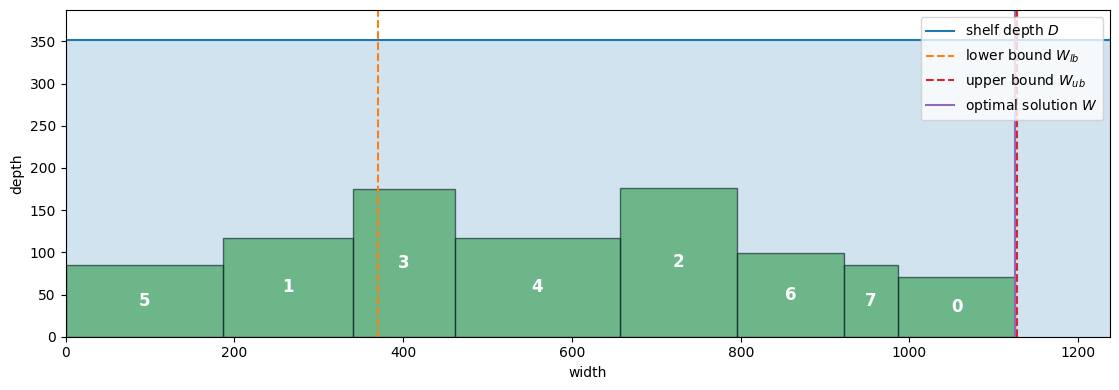

In [4]:
def pack_boxes_V1(boxes):
    # derive the upper bound on shelf width
    W_ub = boxes["w"].sum()

    m = pyo.ConcreteModel("Packing boxes problem")

    m.BOXES = pyo.Set(initialize=boxes.index)
    m.PAIRS = pyo.Set(initialize=m.BOXES * m.BOXES, filter=lambda m, i, j: i < j)

    m.W = pyo.Var(bounds=(0, W_ub))
    m.x1 = pyo.Var(m.BOXES, bounds=(0, W_ub))
    m.x2 = pyo.Var(m.BOXES, bounds=(0, W_ub))

    @m.Objective()
    def minimize_width(m):
        return m.W

    @m.Constraint(m.BOXES)
    def bounding_box(m, i):
        return m.x2[i] == m.x1[i] + boxes.loc[i, "w"]

    @m.Constraint(m.BOXES)
    def width(m, i):
        return m.x2[i] <= m.W

    @m.Disjunction(m.PAIRS, xor=True)
    def no_overlap(m, i, j):
        return [m.x2[i] <= m.x1[j], m.x2[j] <= m.x1[i]]

    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    SOLVER.solve(m)

    soln = boxes.copy()
    soln["x1"] = [m.x1[i]() for i in boxes.index]
    soln["x2"] = [m.x2[i]() for i in boxes.index]
    soln["y1"] = [0 for i in boxes.index]
    soln["y2"] = soln["y1"] + soln["d"]
    soln["r"] = [0 for i in boxes.index]

    return m, soln, W_ub


m, soln, W_ub = pack_boxes_V1(boxes)
display(soln)
show_boxes(soln, D, W_ub)

The solution that we found is not better than the upper bound. This is not surprising, since we did not consider rotation of the boxes.

## Version 2: Rotating boxes

Rotating the boxes is an option for packing the boxes more tightly on the shelf. The boxes can be placed either in their original orientation or in a rotated orientation. This introduces a second exclusive OR disjunction to the model that determines the orientation of the bounding box. A binary indicator variable $r_i$ tracks which boxes were rotated which is used in the `show_boxes` function to show which boxes have been rotated.

$$

\begin{align*}
\min \quad & W \\
\text{s.t} \quad
& x_{i, 2} \leq W  & \forall \, i\\
& x_{i, 1}, x_{i, 2} \geq 0  & \forall \, i \\
& y_{i, 1} = 0 & \forall \, i \\
& [x_{i, 2} \leq x_{j,1}] \veebar [ x_{j, 2} \leq x_{i, 1}] & \forall \, i < j \\

& 
\left[ 
\begin{array}{l}
\begin{array}{l}
r_i = 0 \\
x_{i,2} = x_{i,1} + w_i\\
y_{i,2} = y_{i,1} + d_i\\
\end{array}
\end{array}
\right]
\veebar
\left[ 
\begin{array}{l}
\begin{array}{l}
r_i = 1 \\
x_{i,2} = x_{i,1} + d_i\\
y_{i,2} = y_{i,1} + w_i\\
\end{array}
\end{array}
\right] & \forall \, i < j
\end{align*}

$$

In this version of the model, the boxes will be lined up against the edge of the shelf with $y_{i,1} = 0$. Decision variables are now included in the model for rotation $r$ to the $y$ dimension of the bounding boxes.

,w,d,x1,x2,y1,y2,r
0,138,71,0.000002,71.000002,0.0,138.0,1
1,154,117,631.999999,748.999999,0.0,154.0,1
2,139,176,393.999999,532.999999,0.0,176.0,0
3,121,175,70.999999,191.999999,0.0,175.0,0
4,196,117,276.999999,393.999999,0.0,196.0,1
5,186,85,191.999999,276.999999,0.0,186.0,1
6,126,99,532.999999,631.999999,0.0,126.0,1
7,65,85,748.999999,813.999999,0.0,85.0,0


Lower bound on shelf width = 370
Upper bound on shelf width = 1125
Optimal shelf width = 814


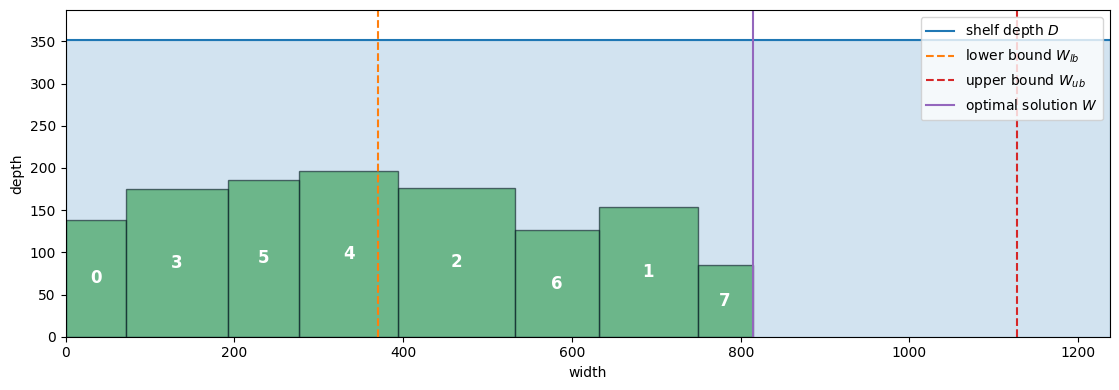

In [5]:
def pack_boxes_V2(boxes):
    W_ub = boxes["w"].sum()

    m = pyo.ConcreteModel("Packing boxes problem with rotation")

    m.BOXES = pyo.Set(initialize=boxes.index)
    m.PAIRS = pyo.Set(initialize=m.BOXES * m.BOXES, filter=lambda m, i, j: i < j)

    m.W = pyo.Var(bounds=(0, W_ub))
    m.x1 = pyo.Var(m.BOXES, bounds=(0, W_ub))
    m.x2 = pyo.Var(m.BOXES, bounds=(0, W_ub))
    m.y1 = pyo.Var(m.BOXES, bounds=(0, W_ub))
    m.y2 = pyo.Var(m.BOXES, bounds=(0, W_ub))
    m.r = pyo.Var(m.BOXES, domain=pyo.Binary)

    @m.Objective()
    def minimize_width(m):
        return m.W

    @m.Constraint(m.BOXES)
    def width(m, i):
        return m.x2[i] <= m.W

    @m.Constraint(m.BOXES)
    def yloc(m, i):
        return m.y1[i] == 0

    @m.Disjunction(m.BOXES)
    def rotate(m, i):
        return [
            [
                m.r[i] == 0,
                m.x2[i] == m.x1[i] + boxes.loc[i, "w"],
                m.y2[i] == m.y1[i] + boxes.loc[i, "d"],
            ],
            [
                m.r[i] == 1,
                m.x2[i] == m.x1[i] + boxes.loc[i, "d"],
                m.y2[i] == m.y1[i] + boxes.loc[i, "w"],
            ],
        ]

    @m.Disjunction(m.PAIRS)
    def no_overlap(m, i, j):
        return [m.x2[i] <= m.x1[j], m.x2[j] <= m.x1[i]]

    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    SOLVER.solve(m)

    soln = boxes.copy()
    soln["x1"] = [m.x1[i]() for i in boxes.index]
    soln["x2"] = [m.x2[i]() for i in boxes.index]
    soln["y1"] = [m.y1[i]() for i in boxes.index]
    soln["y2"] = [m.y2[i]() for i in boxes.index]
    soln["r"] = [int(m.r[i]()) for i in boxes.index]

    return m, soln, W_ub


m, soln, W_ub = pack_boxes_V2(boxes)
display(soln)
show_boxes(soln, D, W_ub)

## Version 3: Placing and Rotating boxes in two dimensions

Obviously the packages can be packed closer together by allowing boxes to be stacked deeper into the shelf. New constraints are needed to maintain the bounding boxes within the shelf depth, and to avoid overlaps in the $y$ dimension.

$$
\begin{align*}
\min \quad & W \\
\text{s.t.} \quad
& x_{i, 2}  \leq W & \forall i\\
& y_{i, 2}  \leq D & \forall i\\
& x_{i, 1}, x_{i, 2}  \geq 0  & \forall i \\
& y_{i, 1}, y_{i, 2}  \geq 0 & \forall i \\
& \begin{bmatrix}
x_{i, 2} \leq x_{j,1} \\
\end{bmatrix}
\veebar
\begin{bmatrix}
x_{j, 2} \leq x_{i, 1} \\
\end{bmatrix}
 \veebar 
\begin{bmatrix}
y_{i, 2} \leq y_{j, 1} \\
\end{bmatrix}
\veebar
\begin{bmatrix}
y_{j, 2} \leq y_{i, 1} \\
\end{bmatrix}
& \forall i < j \\
& \begin{bmatrix}
r_i = 0 \\
x_{i,2} = x_{i,1} + w_i\\
y_{i,2} = y_{i,1} + d_i\\
\end{bmatrix}  \veebar 
\begin{bmatrix}
r_i = 1 \\
x_{i,2} = x_{i,1} + d_i\\
y_{i,2} = y_{i,1} + w_i\\
\end{bmatrix} & \forall i < j
\end{align*}
$$


,w,d,x1,x2,y1,y2,r
0,138,71,1.170000e+02,255.0,196.0,267.0,0
1,154,117,0.000000e+00,117.0,99.0,253.0,1
2,139,176,2.430000e+02,382.0,-0.0,176.0,0
3,121,175,2.550000e+02,376.0,177.0,352.0,0
4,196,117,1.260000e+02,243.0,-0.0,196.0,1
5,186,85,-2.709165e-14,186.0,267.0,352.0,0
6,126,99,1.311662e-11,126.0,-0.0,99.0,0
7,65,85,1.860000e+02,251.0,267.0,352.0,0


Lower bound on shelf width = 370
Upper bound on shelf width = 1125
Optimal shelf width = 382


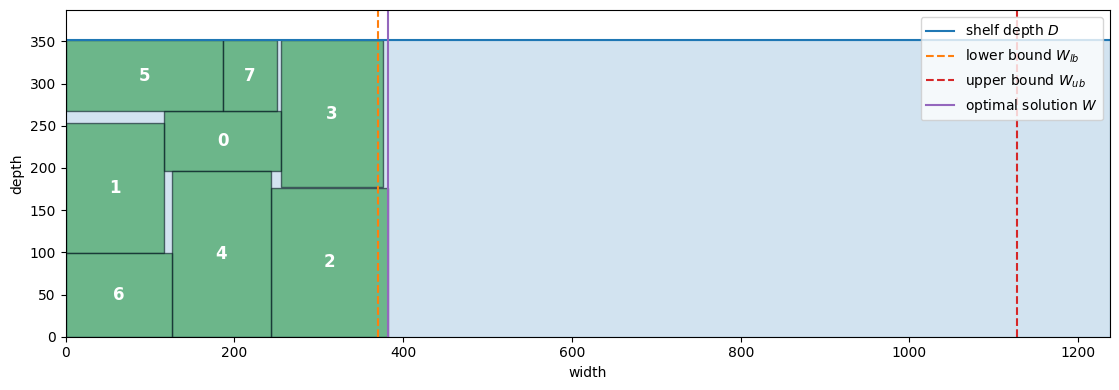

In [6]:
def pack_boxes_V3(boxes, D):
    W_ub = boxes["w"].sum()

    m = pyo.ConcreteModel("Packing boxes problem with rotation and shelf depth")

    m.D = pyo.Param(mutable=True, initialize=D)

    m.BOXES = pyo.Set(initialize=boxes.index)
    m.PAIRS = pyo.Set(initialize=m.BOXES * m.BOXES, filter=lambda m, i, j: i < j)

    m.W = pyo.Var(bounds=(0, W_ub))
    m.x1 = pyo.Var(m.BOXES, bounds=(0, W_ub))
    m.x2 = pyo.Var(m.BOXES, bounds=(0, W_ub))
    m.y1 = pyo.Var(m.BOXES, bounds=(0, W_ub))
    m.y2 = pyo.Var(m.BOXES, bounds=(0, W_ub))
    m.r = pyo.Var(m.BOXES, domain=pyo.Binary)

    @m.Objective()
    def minimize_width(m):
        return m.W

    @m.Constraint(m.BOXES)
    def width(m, i):
        return m.x2[i] <= m.W

    @m.Constraint(m.BOXES)
    def height(m, i):
        return m.y2[i] <= m.D

    @m.Disjunction(m.BOXES)
    def rotate(m, i):
        return [
            [
                m.r[i] == 0,
                m.x2[i] == m.x1[i] + boxes.loc[i, "w"],
                m.y2[i] == m.y1[i] + boxes.loc[i, "d"],
            ],
            [
                m.r[i] == 1,
                m.x2[i] == m.x1[i] + boxes.loc[i, "d"],
                m.y2[i] == m.y1[i] + boxes.loc[i, "w"],
            ],
        ]

    @m.Disjunction(m.PAIRS)
    def no_overlap(m, i, j):
        return [
            m.x2[i] <= m.x1[j],
            m.x2[j] <= m.x1[i],
            m.y2[i] <= m.y1[j],
            m.y2[j] <= m.y1[i],
        ]

    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    SOLVER.solve(m)

    soln = boxes.copy()
    soln["x1"] = [m.x1[i]() for i in boxes.index]
    soln["x2"] = [m.x2[i]() for i in boxes.index]
    soln["y1"] = [m.y1[i]() for i in boxes.index]
    soln["y2"] = [m.y2[i]() for i in boxes.index]
    soln["r"] = [int(m.r[i]()) for i in boxes.index]

    return m, soln, W_ub


m, soln, W_ub = pack_boxes_V3(boxes, D)
display(soln)
show_boxes(soln, D, W_ub)

## Advanced Topic: Symmetry Breaking

One of the issues in combinatorial problem is the challenge of symmetries. A symmetry is a situation where a change in solution configuration leaves the objective unchanged. Strip packing problems are especially susceptible to symmetries. Symmetries can significantly increase the effort needed to find and verify an optimal solution. In [1], Trespalacios and Grossmann introduced a modification to the strip packing problem to reduce the number of symmetries. We implement this new model formulation in Pyomo in the following cell.

[1] _Trespalacios, F., & Grossmann, I. E. (2017). Symmetry breaking for generalized disjunctive programming formulation of the strip packing problem. Annals of Operations Research, 258(2), 747-759. DOI [10.1007/s10479-016-2112-9](https://doi.org/10.1007/s10479-016-2112-9)_

,w,d,x1,x2,y1,y2,r
0,138,71,121.0,259.0,85.0,156.0,0
1,154,117,259.0,376.0,85.0,239.0,1
2,139,176,-0.0,139.0,175.0,351.0,0
3,121,175,-0.0,121.0,0.0,175.0,0
4,196,117,139.0,256.0,156.0,352.0,1
5,186,85,186.0,372.0,-0.0,85.0,0
6,126,99,256.0,382.0,239.0,338.0,0
7,65,85,121.0,186.0,0.0,85.0,0


Lower bound on shelf width = 370
Upper bound on shelf width = 1125
Optimal shelf width = 382


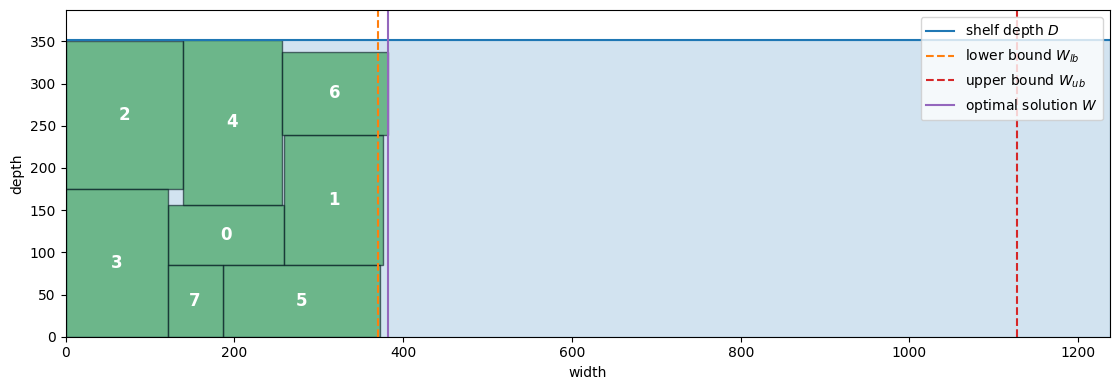

In [7]:
def pack_boxes_V4(boxes, D):
    W_ub = boxes["w"].sum()

    m = pyo.ConcreteModel(
        "Packing boxes problem with rotation and shelf depth (symmetry breaking model)"
    )

    m.D = pyo.Param(mutable=True, initialize=D)

    m.BOXES = pyo.Set(initialize=boxes.index)
    m.PAIRS = pyo.Set(initialize=m.BOXES * m.BOXES, filter=lambda m, i, j: i < j)

    m.W = pyo.Var(bounds=(0, W_ub))
    m.x1 = pyo.Var(m.BOXES, bounds=(0, W_ub))
    m.x2 = pyo.Var(m.BOXES, bounds=(0, W_ub))
    m.y1 = pyo.Var(m.BOXES, bounds=(0, W_ub))
    m.y2 = pyo.Var(m.BOXES, bounds=(0, W_ub))
    m.r = pyo.Var(m.BOXES, domain=pyo.Binary)

    @m.Objective()
    def minimize_width(m):
        return m.W

    @m.Constraint(m.BOXES)
    def width(m, i):
        return m.x2[i] <= m.W

    @m.Constraint(m.BOXES)
    def height(m, i):
        return m.y2[i] <= m.D

    @m.Disjunction(m.BOXES)
    def rotate(m, i):
        return [
            [
                m.r[i] == 0,
                m.x2[i] == m.x1[i] + boxes.loc[i, "w"],
                m.y2[i] == m.y1[i] + boxes.loc[i, "d"],
            ],
            [
                m.r[i] == 1,
                m.x2[i] == m.x1[i] + boxes.loc[i, "d"],
                m.y2[i] == m.y1[i] + boxes.loc[i, "w"],
            ],
        ]

    @m.Disjunction(m.PAIRS)
    def no_overlap(m, i, j):
        return [
            [m.x2[i] <= m.x1[j]],
            [m.x2[j] <= m.x1[i]],
            [m.y2[i] <= m.y1[j], m.x2[i] >= m.x1[j] + 1, m.x2[j] >= m.x1[i] + 1],
            [m.y2[j] <= m.y1[i], m.x2[i] >= m.x1[j] + 1, m.x2[j] >= m.x1[i] + 1],
        ]

    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    SOLVER.solve(m)

    soln = boxes.copy()
    soln["x1"] = [m.x1[i]() for i in m.BOXES]
    soln["x2"] = [m.x2[i]() for i in m.BOXES]
    soln["y1"] = [m.y1[i]() for i in m.BOXES]
    soln["y2"] = [m.y2[i]() for i in m.BOXES]
    soln["r"] = [int(m.r[i]()) for i in m.BOXES]

    return m, soln, W_ub


m, soln, W_ub = pack_boxes_V4(boxes, D)
display(soln)
show_boxes(soln, D, W_ub)